# Coronavirus Statistics

This notebook is a work-in-progress for playing with the coronavirus statistics published by [Johns Hopkins university github repo](https://github.com/CSSEGISandData/COVID-19), which forms the foundation for the visualisations published in their [COVID-19 Dashboard](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6). Testing data is taken from [Our World In Data](https://ourworldindata.org).

In [1]:
from datetime import datetime, timedelta
from IPython.display import Markdown as md

md(f"#### Last Updated: {datetime.today().astimezone().strftime('%Y-%m-%d %H:%M %Z')}")

#### Last Updated: 2020-09-02 20:15 BST

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

countries_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
cases_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

countries_raw = pd.read_csv(countries_csv)
cases_raw = pd.read_csv(cases_csv)
cases = cases_raw[~cases_raw["Province/State"].isin(["Recovered", "Diamond Princess", "Grand Princess"])].groupby("Country/Region").sum().iloc[:, 2:]
deaths_raw = pd.read_csv(deaths_csv)
deaths = deaths_raw[~deaths_raw["Province/State"].isin(["Recovered", "Diamond Princess", "Grand Princess"])].groupby("Country/Region").sum().iloc[:, 2:]

#### Limit the data to the countries in which we're interested
We're not interested in all data. For cases, we take all the countries where the number of cases is greater than the number of Swiss cases. For deaths, we take the top twenty cases.

In [3]:
last_col_name = cases.columns[-1]

force_countries = ["Canada", "Austria", "Switzerland"]

cases_interest = cases.sort_values(by=last_col_name, ascending=False).iloc[:20, :]
deaths_interest = deaths.sort_values(by=last_col_name, ascending=False).iloc[:20, :]
for country in force_countries:
    cases_interest.loc[country] = cases.loc[country]
    deaths_interest.loc[country] = deaths.loc[country]

By changing `num_days` we can control the number of days shown in the graphs. The first days of data are only interesting for China, whereas the rest of the world picks up starting in early March. Uncomment one of the variants for `num_days` below, depending on what you want to see:

* Choose a starting date
* Choose a number of historical days since today
* Choose all days for which there is data

In [4]:
# Starting date, e.g. March 15 2020
num_days = (datetime.today() - datetime(2020, 3, 15)).days

# Number of historical days
# num_days = 15

# All data
# num_days = None

## Graphs

The graphs below use various subplots to try and allow different y-axis scales, given the wide range of cases and deaths. The various proportions will probably need to be adjusted as time progresses and the actual numbers and relative scales evolve.

**Set the font size for the titles, ticks, and annotations**

In [5]:
fontsize = 10

**Define a generic function for plotting data in a set of subplots**

In [6]:
def get_axis(axes, idx):
    try:
        i = iter(axes)
    except:
        return axes
    else:
        return axes[idx]

def plot_data(data, splits, ratios, title, decimals=0, figsize=(15, 15)):
    fig, axes = plt.subplots(len(splits), 1, figsize=figsize, gridspec_kw={"height_ratios": ratios})
    fig.tight_layout()
    
    get_axis(axes, 0).set(title=title)

    start = 0
    for idx in range(len(splits)):
        splitcount = splits[idx]
        end = start + splitcount if splitcount else None
        ax = get_axis(axes, idx)
        ax.grid()
        plotdata = data.iloc[:, start:end]
        labels = list(data.columns[start:end])
        ax.plot(plotdata)
        ax.legend([f"{x}" for x in labels], loc="upper left")

        last_idx = -1
        last_data = plotdata.iloc[[last_idx]]
        while np.isnan(last_data.values.flatten()[0]):
            last_idx -= 1
            last_data = plotdata.iloc[[last_idx]]
        
        for key, vals in last_data.items():
            label = f"%.{decimals}f - %s"
            ax.annotate(label % (vals.values[0], key), (vals.index, vals.values[0]), xytext=(10, -3), textcoords="offset points", fontsize=fontsize)

        start = end

### Numbers of confirmed cases

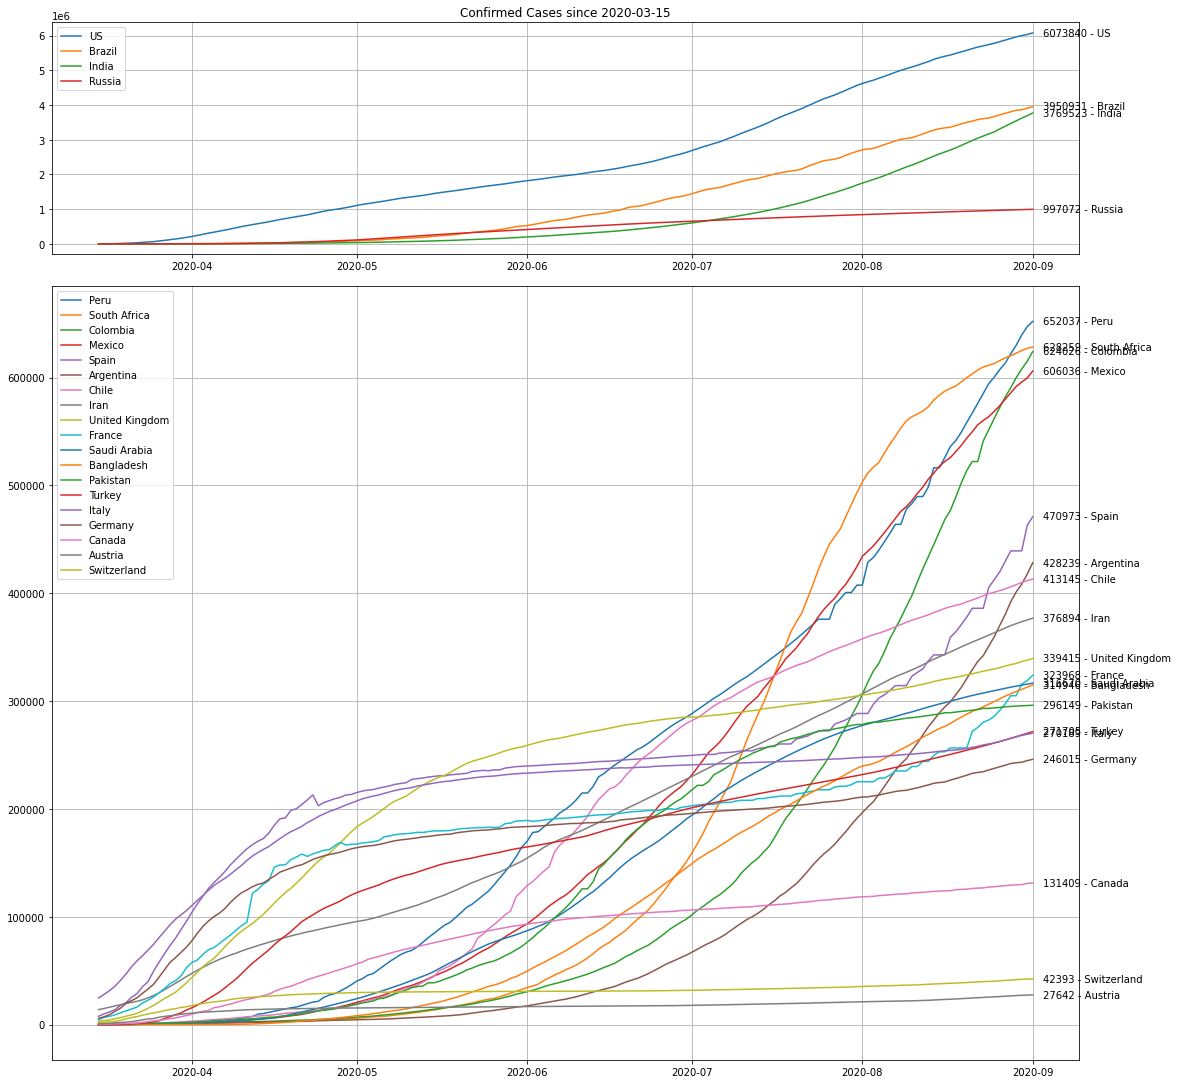

In [7]:
def confirmed_cases(days=num_days):
    cases_trim = cases_interest.T
    cases_trim = cases_trim.iloc[-days:, :]

    cases_trim.index = pd.to_datetime(cases_trim.index)

    splits = [4, None]
    ratios = [3, 10]

    plot_data(cases_trim, splits, ratios, f"Confirmed Cases since {(datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')}")

confirmed_cases()

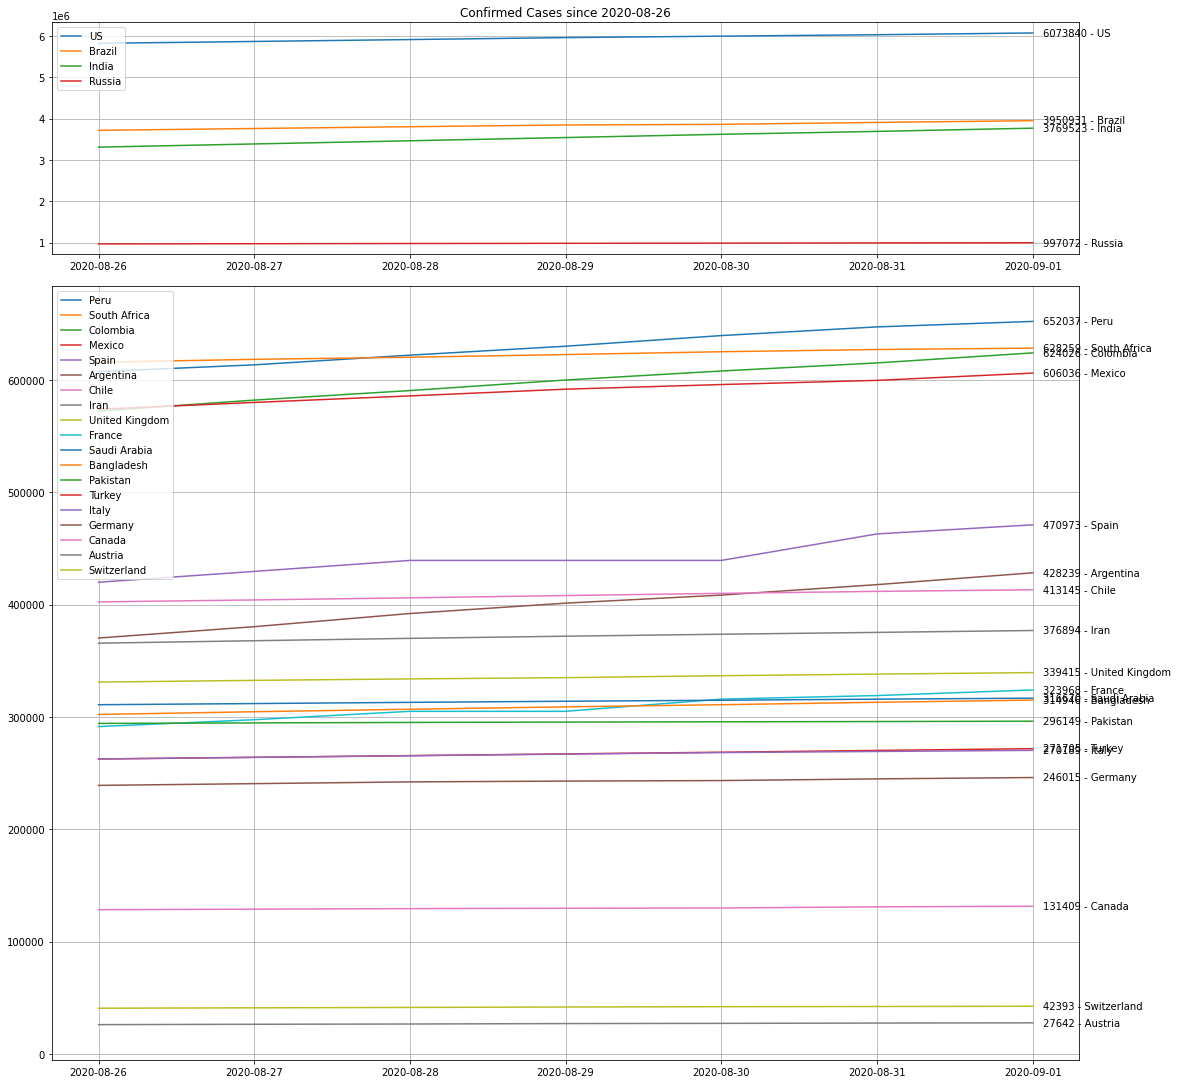

In [8]:
confirmed_cases(7)

### Number of confirmed deaths

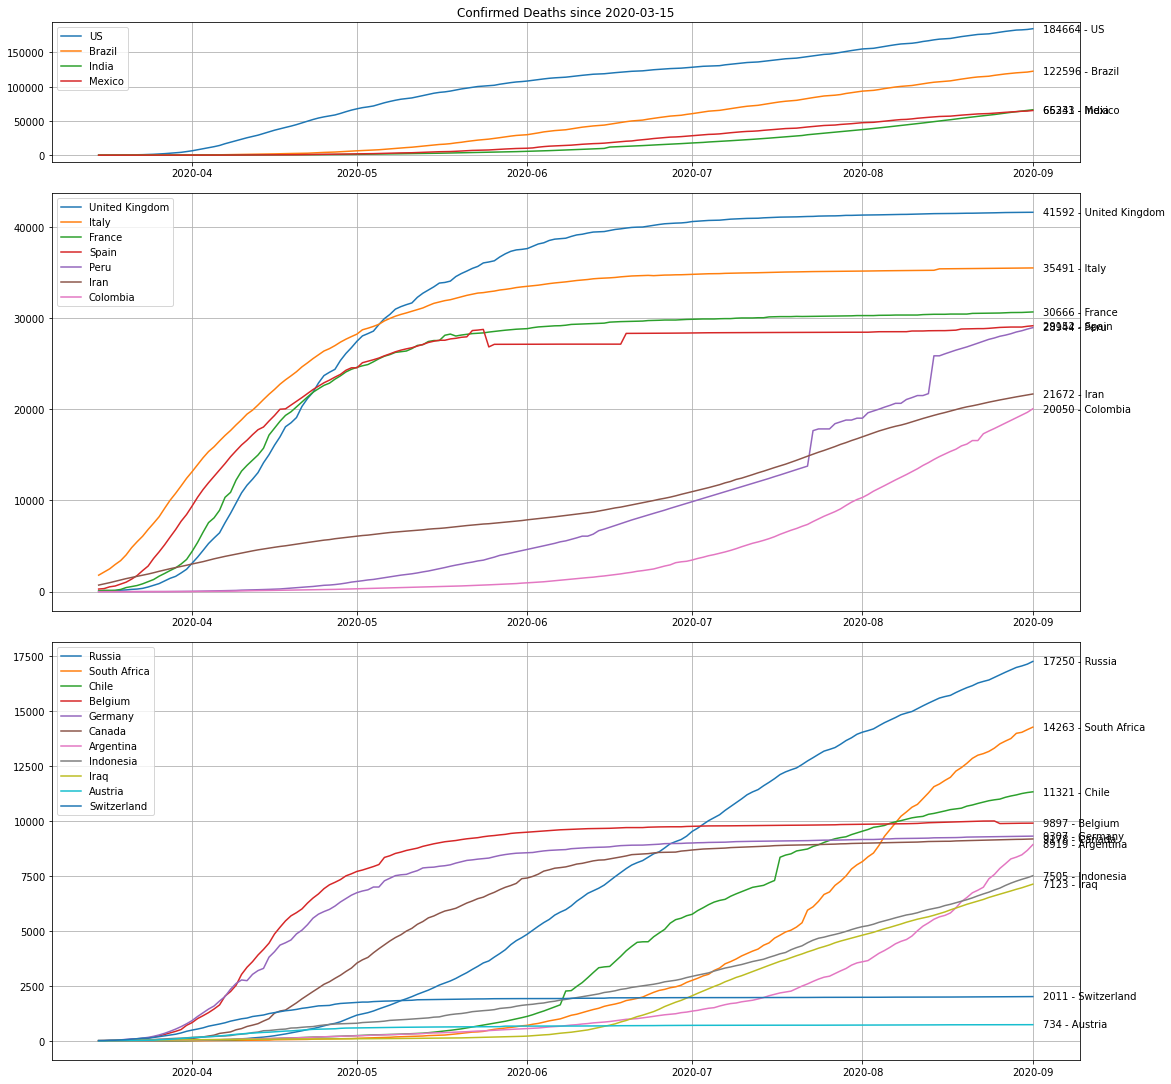

In [9]:
def confirmed_deaths(days=num_days):
    deaths_trim = deaths_interest.T
    deaths_trim = deaths_trim.iloc[-days:, :]

    deaths_trim.index = pd.to_datetime(deaths_trim.index)

    splits = [4, 7, None]
    ratios = [1, 3, 3]

    plot_data(deaths_trim, splits, ratios,  f"Confirmed Deaths since {(datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')}")

confirmed_deaths()

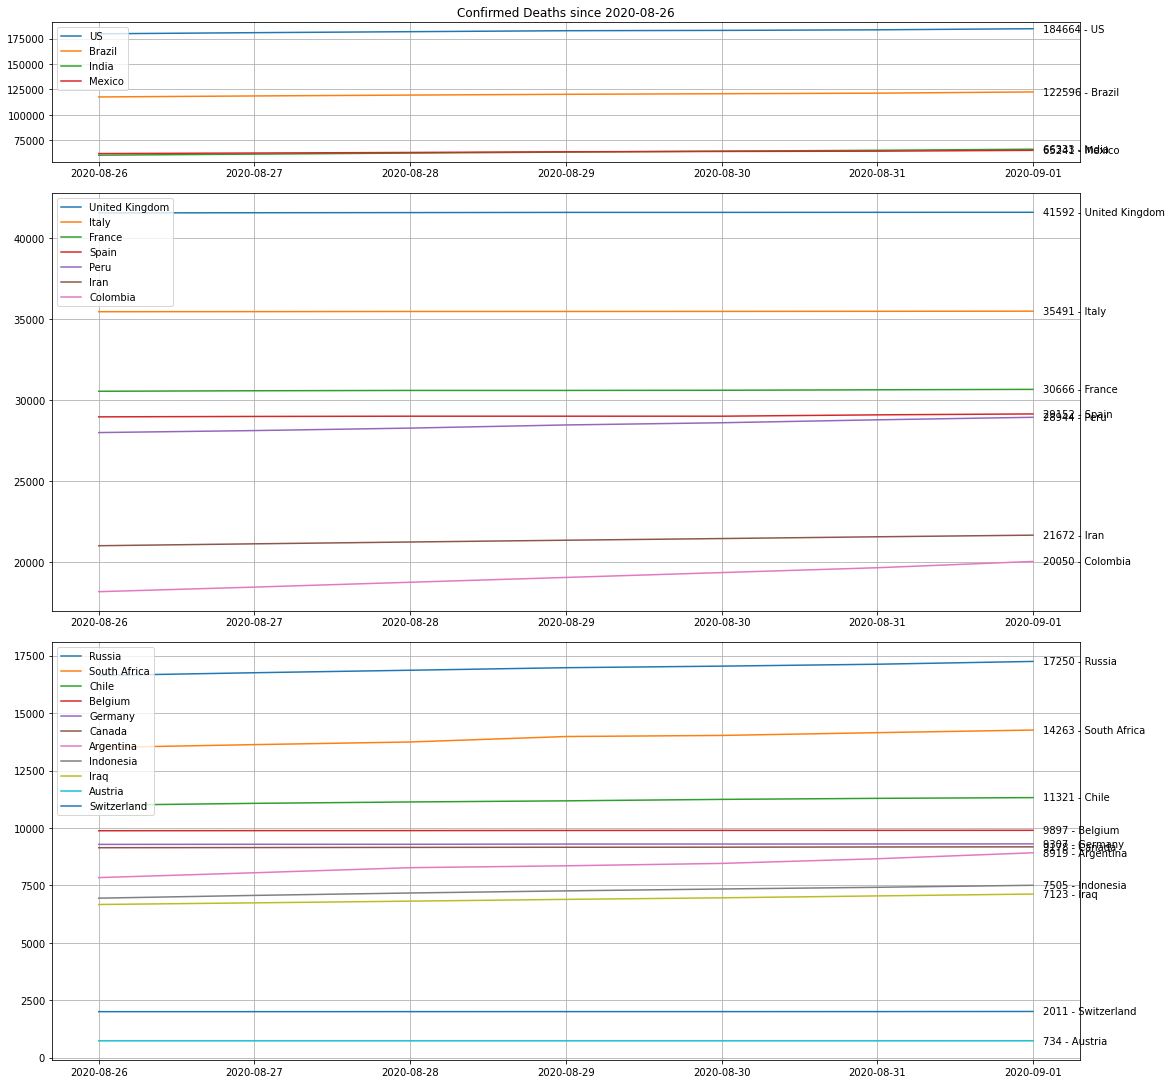

In [10]:
confirmed_deaths(7)

### Number of confirmed deaths per 100'000 inhabitants over time

The graphs show all the countries where the number of deaths per 100k as of today is at least 10.0

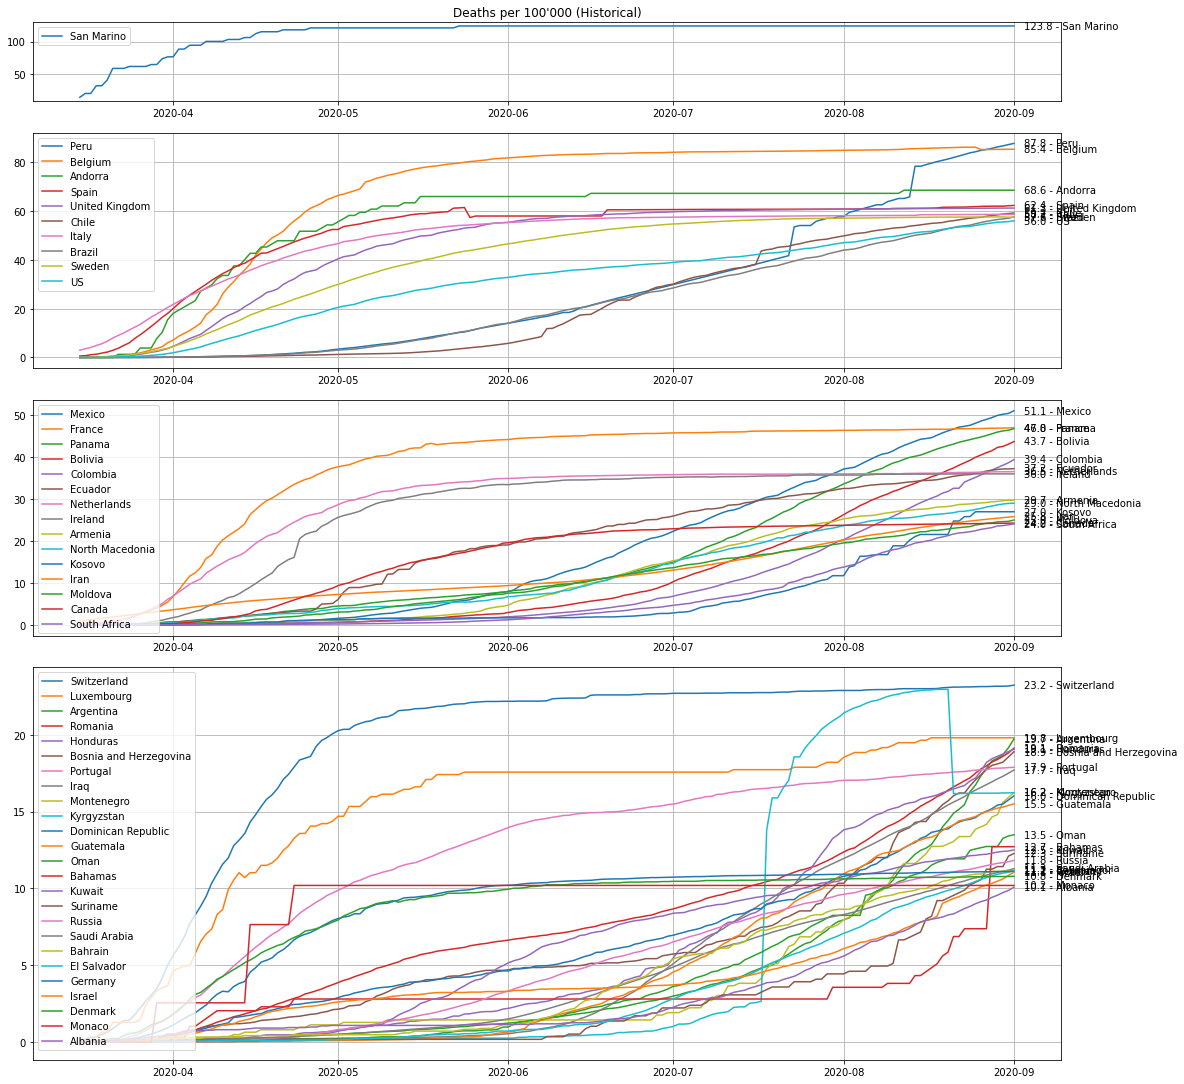

In [11]:
dpm = pd.DataFrame()

for k, v in deaths.T.items():
    pop = countries_raw[countries_raw["Combined_Key"] == k]["Population"]
    try:
        factor = 100000 / int(pop)
        series = v.mul(factor)
        dpm = dpm.append(series)
    except:
        pass

dpm.columns = pd.to_datetime(dpm.columns)
dpm.sort_index(inplace=True, axis=1)
dpm = dpm.sort_values(by=last_col_name, ascending=False).iloc[:, -num_days:]
dpm_interest = dpm[dpm[last_col_name] >= 10.0]

splits = [1, 10, 15, None]
ratios = [1, 3, 3, 5]

plot_data(dpm_interest.T, splits, ratios, "Deaths per 100'000 (Historical)", decimals=1)

### Current number of confirmed deaths per 100'000 inhabitants

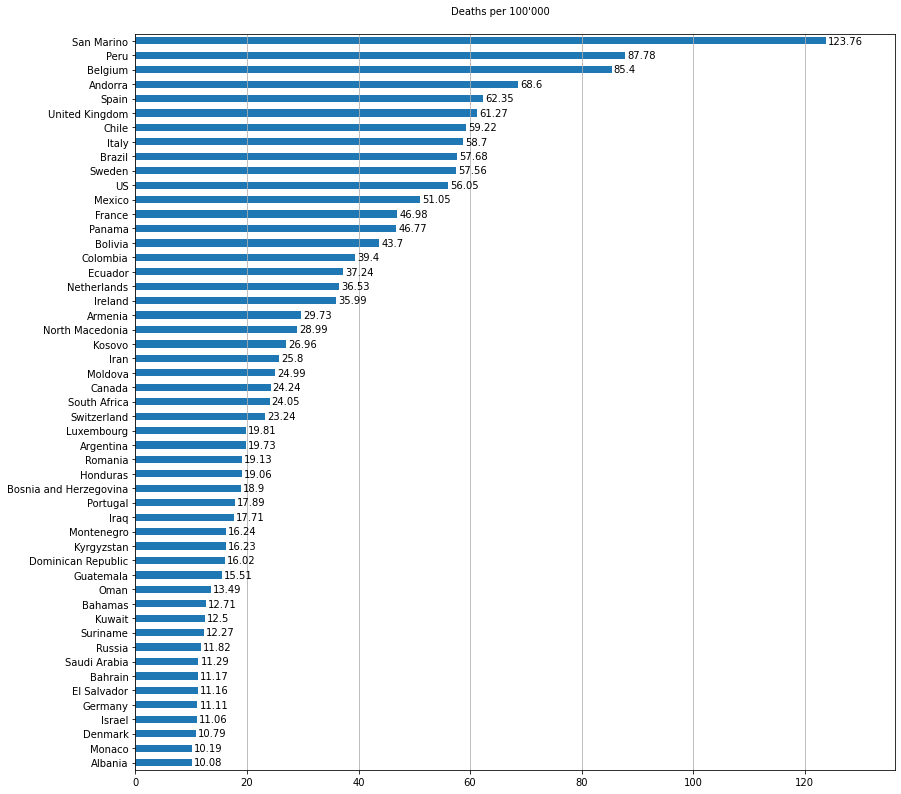

In [12]:
dpm_today = dpm_interest.iloc[:, -1:].sort_values(by=last_col_name)

fig, axes = plt.subplots()
fig.tight_layout(h_pad=0)
dpm_today.plot(kind="barh", figsize=(12, 12), legend=None, ax=axes, fontsize=fontsize)
axes.grid(axis="x")
axes.margins(0.10)
fig.suptitle("Deaths per 100'000", fontsize=fontsize)

i = 0
for k, v in dpm_today.iterrows():
    val = round(v[-1], 2)
    axes.annotate(val, (val, i), xytext=(2, -3), textcoords="offset points", fontsize=fontsize)
    i += 1

### Rates of Testing

This uses data from the [Our World In Data Coronavirus Testing dataset](https://ourworldindata.org/coronavirus-testing) to show how testing is evolving.

In [13]:
owid_csv = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
owid_dtypes = {"iso_code": str, "continent": str, "tests_units": str}
owid_data_raw = pd.read_csv(owid_csv, dtype=owid_dtypes)

In [14]:
def get_owid_data(codes, cols):
    if type(cols) not in (list, tuple):
        cols = [cols]
    owid_data = owid_data_raw.loc[:, ["iso_code", "date", "location"] + cols].set_index("date")
    results = {}
    
    for col in cols:
        frame = pd.DataFrame()
        for code in codes:
            location = owid_data[owid_data["iso_code"] == code]
            frame[location.iloc[1]["location"]] = location[col]
        frame.index = pd.to_datetime(frame.index)
        results[col] = frame
    
    if len(cols) == 1:
        return results[cols[0]]
    else:
        return results

### New Tests per Thousand

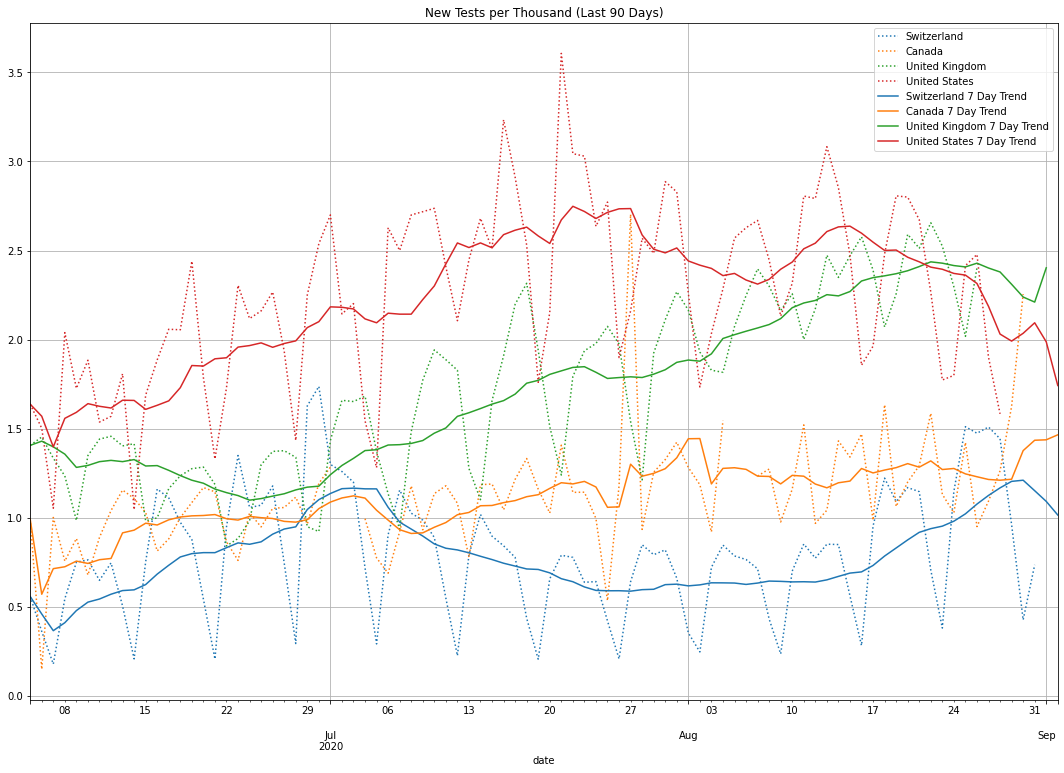

In [15]:
days = 90
codes = ["CHE", "CAN", "GBR", "USA"]

owid_ntpt = get_owid_data(codes, "new_tests_per_thousand").iloc[-days:, :]
trend = owid_ntpt.rolling("7d").mean()
trend.columns = [f"{x} 7 Day Trend" for x in trend.columns]

fig, axes = plt.subplots(figsize=(15, 10))
fig.tight_layout(h_pad=0)
axes.set(title=f"New Tests per Thousand (Last {days} Days)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

axes.set_prop_cycle(color=colors)
owid_ntpt.plot(ax=axes, grid=True, linestyle=":")

axes.set_prop_cycle(color=colors)
trend.plot(ax=axes, grid=True)

plt.show()

### Tests per Case

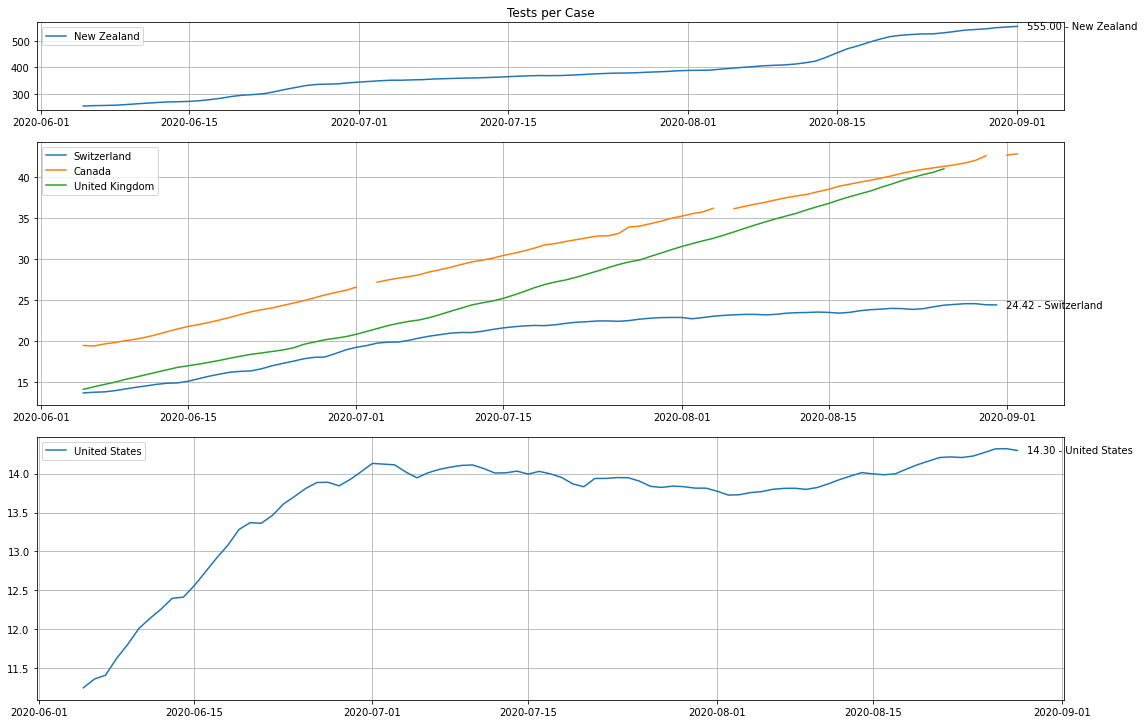

In [16]:
owid = get_owid_data(["NZL"] + codes, ["total_tests", "total_cases"])
owid_nc = owid["total_tests"] / owid["total_cases"]
owid_nc = owid_nc.iloc[-days:, :]

splits = [1, 3, 1]
ratios = [1, 3, 3]
plot_data(owid_nc, splits, ratios, "Tests per Case", decimals=2, figsize=(15, 10))

## Daily Statistics and Rolling Trends

Now that the lockdowns are being progressively lifted, these statistics will show if there is a resurgence of new cases and deaths.

### Plotting function

In [17]:
def plot_dailies(data, title, splits, dates):
    start = 0
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, axes = plt.subplots(len(splits), 1, figsize=(15, 5 * len(splits)))
    fig.tight_layout()

    get_axis(axes, 0).set(title=title)

    for split in range(len(splits)):
        splitcount = splits[split]
        end = start + splitcount if splitcount else None
        ax = get_axis(axes, split)
        ax.grid()
        ax.set_prop_cycle(color=colors[start:end])
        data_range = data.iloc[:, start:end]
        trend = data_range.rolling("14d").mean()
        dlabels = list(data_range.columns)
        labels = []

        for i in range(0, len(dlabels)):
            labels.append(f"{dlabels[i]} 14 Day Trend")
        for i in range(0, len(dlabels)):
            labels.append(f"{dlabels[i]} Data")
            
        ax.plot(trend)
        ax.plot(data_range, linestyle=":")

        ax.legend(labels)

        last_data = data_range.iloc[-1]
        last_trend = trend.iloc[-1]
        for val in last_trend.values:
            ax.annotate(round(val, 1), (last_trend.name, val), xytext=(2, -3),
                        textcoords="offset points", fontsize=fontsize)
        for val in last_data.values:
            ax.annotate(int(round(val, 0)), (last_data.name, val), xytext=(2, -3),
                        textcoords="offset points", fontsize=fontsize)

        start = end

    lineheight = 0.90
    chax = get_axis(axes, -1)
    chdata = data.iloc[:, -1]
    chtrend = chdata.rolling("14d").mean()

    for date in dates:
        at = pd.Timestamp(date[0])
        if at in data.index and not data.loc[at].isna()[0]:
            line = chax.axvline(at, color="g", ls="--", ymax=lineheight)
            text = date[1].format(date[0])
            chax.annotate(text, (at, chax.viewLim.height * lineheight), xytext=(5, -5), 
                          textcoords="offset points", fontsize=fontsize, verticalalignment="top")
            atval = chtrend[at]
            chax.annotate(round(atval, 1), (at, atval), xytext=(-10, 30),
                         textcoords="offset points", fontsize=fontsize, horizontalalignment="right",
                         arrowprops={"arrowstyle": "-"})
    
    plt.show()

### Configuration options

In [18]:
# Number of days to consider
days = 60

# Countries to consider
dailies_countries = ["US", "Spain", "United Kingdom", "Canada", "Austria", "Switzerland"]

# How to split the countries into sub-plots
splits = [1, 2, None]

# Annotations for important dates in Switzerland's easing of restrictions
dates = [
    ("2020-04-27", "Phase 1\n{}\nHealthcare, DIY\nPersonal services"),
    ("2020-05-11", "Phase 2\n{}\nSchools, shops\nRestaurants up to 4"),
    ("2020-05-30", "Phase 3\n{}\nReligous services\nPublic up to 30"),
    ("2020-06-06", "Phase 4\n{}\nEvents up to 300"),
    ("2020-06-15", "EU Borders\n{}"),
    ("2020-06-22", "Most restrictions\nlifted\n{}")
]

### Daily Cases

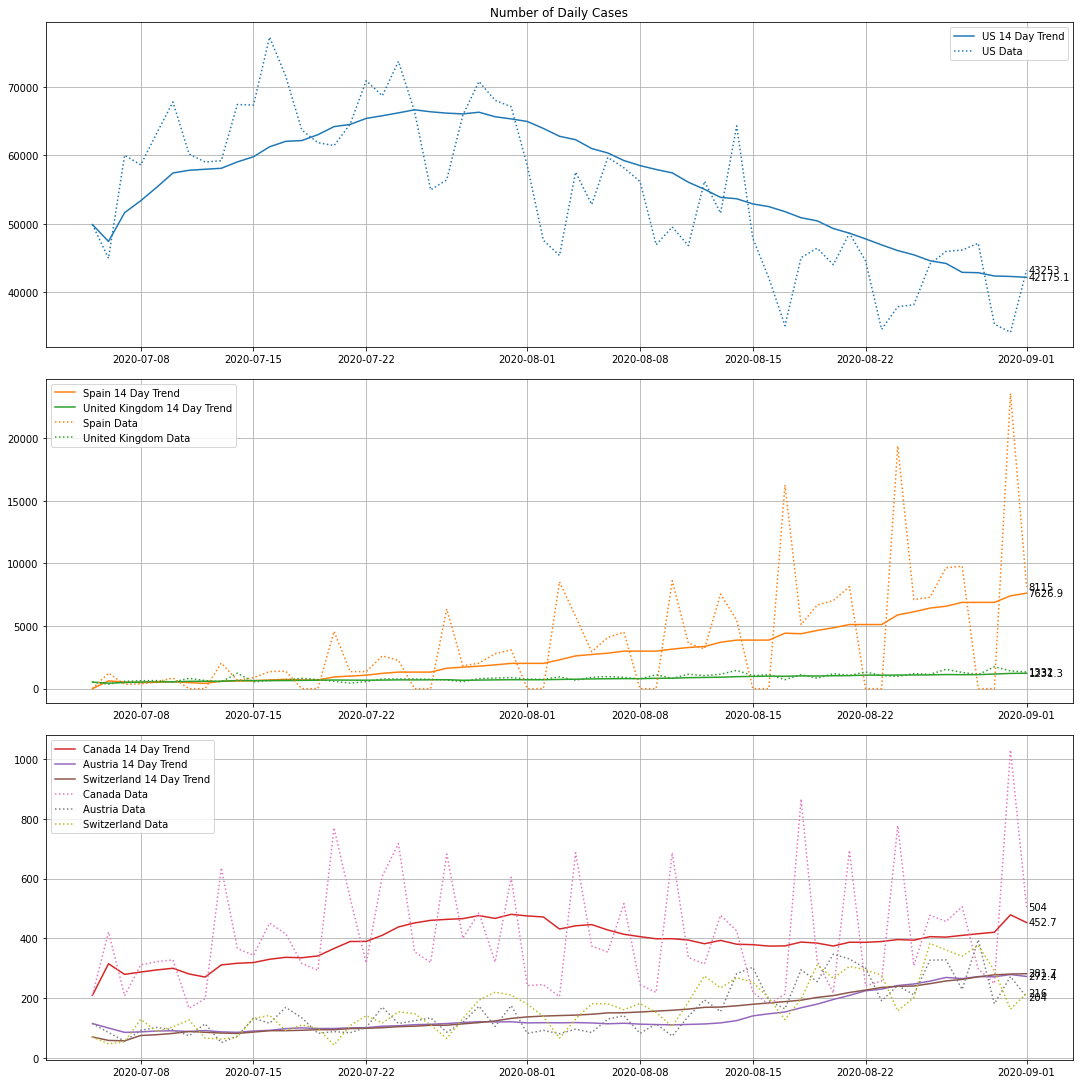

In [19]:
dailies_cases = cases_interest.loc[dailies_countries].iloc[:, -days:].T.diff()
dailies_cases.index = pd.to_datetime(dailies_cases.index)
plot_dailies(dailies_cases, "Number of Daily Cases", splits, dates)

### Daily Cases as Percentage Change

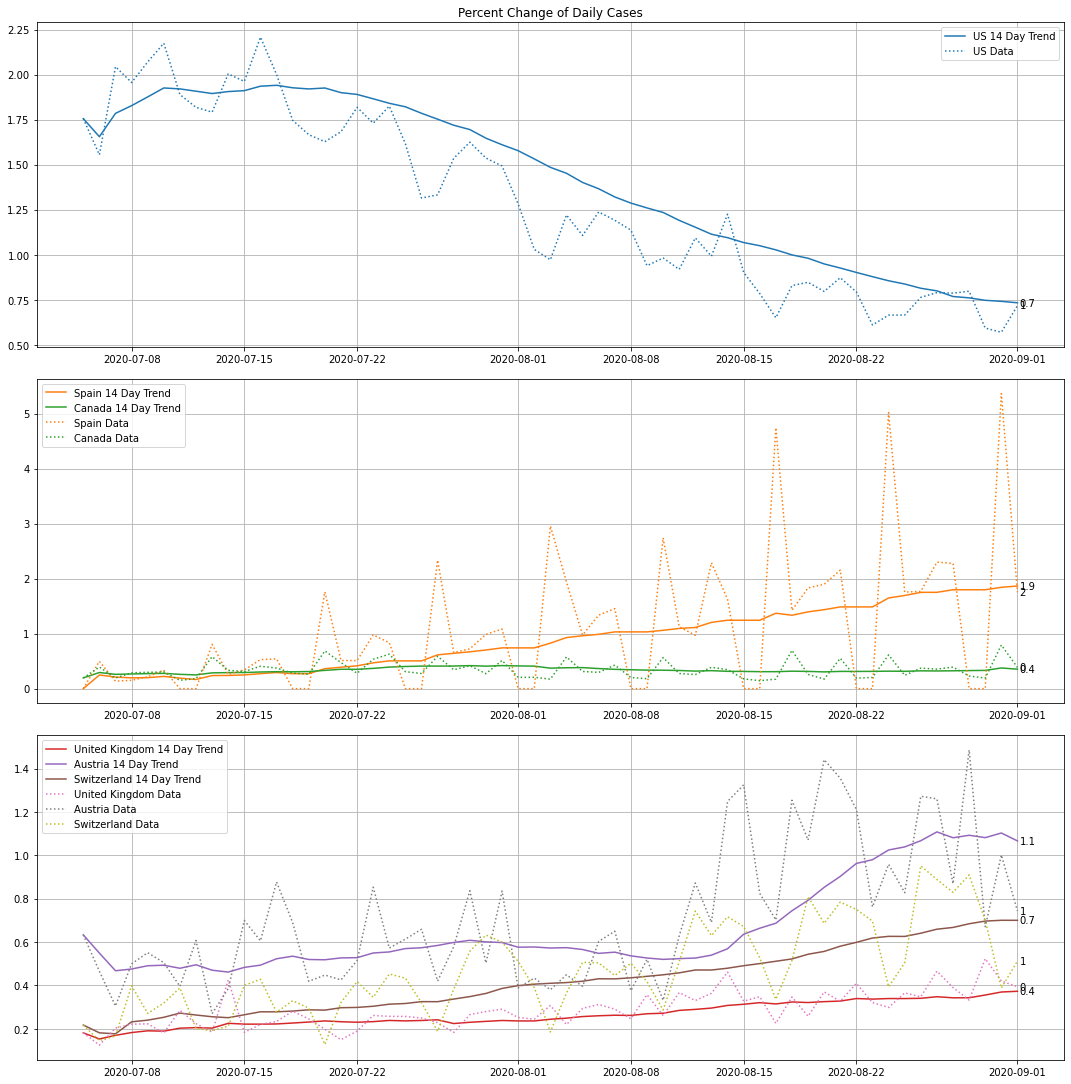

In [20]:
dailies_countries = ["US", "Spain", "Canada", "United Kingdom", "Austria", "Switzerland"]

dailies_pct_cases = cases_interest.loc[dailies_countries].iloc[:, -days:].T.pct_change().mul(100)
dailies_pct_cases.index = pd.to_datetime(dailies_pct_cases.index)
plot_dailies(dailies_pct_cases, "Percent Change of Daily Cases", splits, dates)

### Daily Cases per 100'000

/Users/harris/Workspaces/Envs/coronastats/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


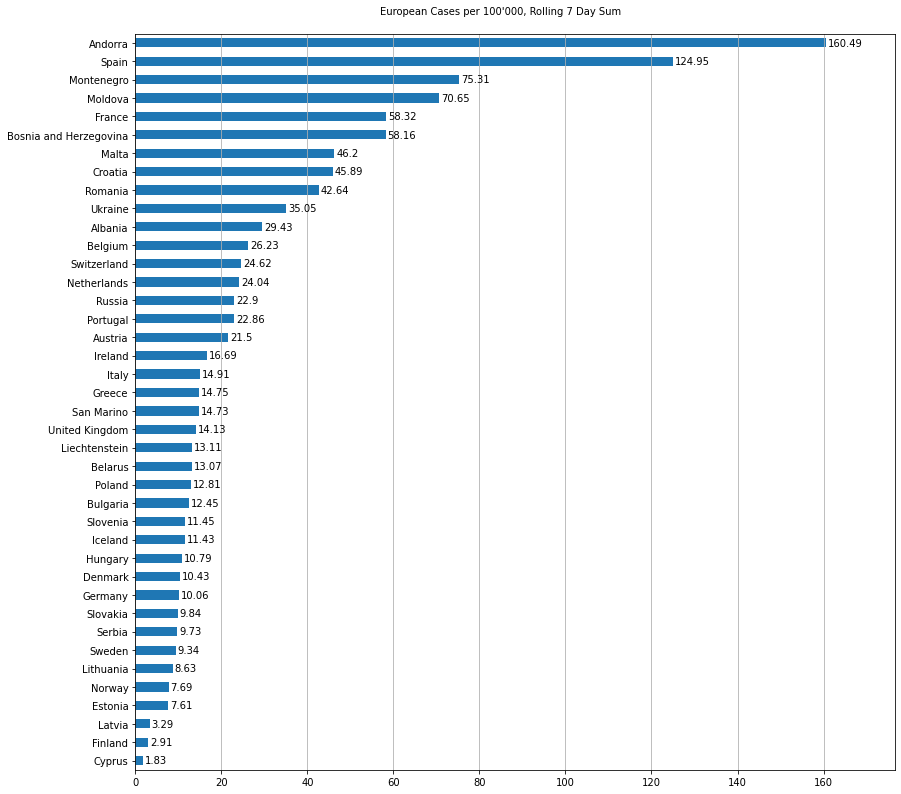

In [26]:
cpm = pd.DataFrame()

country_map = {
    "US": "United States"
}

for k, v in cases.T.diff().rolling(7).sum().items():
    try:
        country = country_map.get(k, k)
        pop, continent = owid_data_raw[owid_data_raw["location"] == country].iloc[-1][["population", "continent"]]
    except:
#         print(f"Didn't find {k}")
        continue

    if continent == "Europe":
        try:
            factor = 100000 / int(pop)
            series = v.mul(factor)
            cpm = cpm.append(series)
        except:
            pass

cpm.columns = pd.to_datetime(cpm.columns)
cpm.sort_index(inplace=True, axis=1)
cpm = cpm.sort_values(by=last_col_name, ascending=False).iloc[:, -num_days:]
# cpm_interest = cpm[cpm[last_col_name] >= 18.0]
# cpm_interest = cpm.loc[dailies_countries]
cpm_interest = cpm

cpm_today = cpm_interest.iloc[:, -1:][(cpm_today > 0).all(1)].sort_values(by=last_col_name)

fig, axes = plt.subplots()
fig.tight_layout(h_pad=0)
cpm_today.plot(kind="barh", figsize=(12, 12), legend=None, ax=axes, fontsize=fontsize)
axes.grid(axis="x")
axes.margins(0.10)
fig.suptitle("European Cases per 100'000, Rolling 7 Day Sum", fontsize=fontsize)

i = 0
for k, v in cpm_today.iterrows():
    val = round(v[-1], 2)
    axes.annotate(val, (val, i), xytext=(2, -3), textcoords="offset points", fontsize=fontsize)
    i += 1

### Daily Deaths

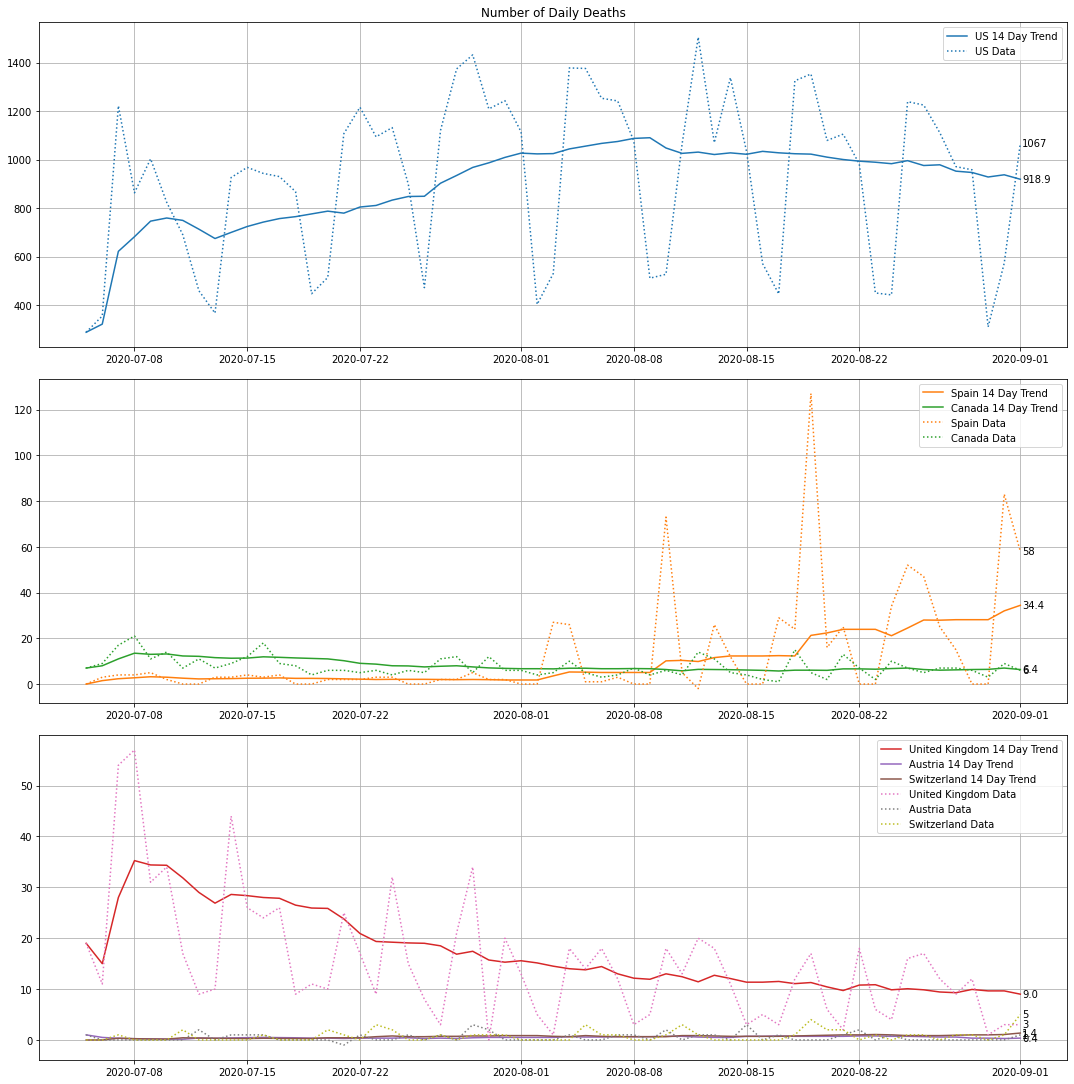

In [22]:
dailies_deaths = deaths.loc[dailies_countries].iloc[:, -days:].T.diff()
dailies_deaths.index = pd.to_datetime(dailies_deaths.index)
plot_dailies(dailies_deaths, "Number of Daily Deaths", splits, dates)

### Daily Deaths divided by Daily Cases

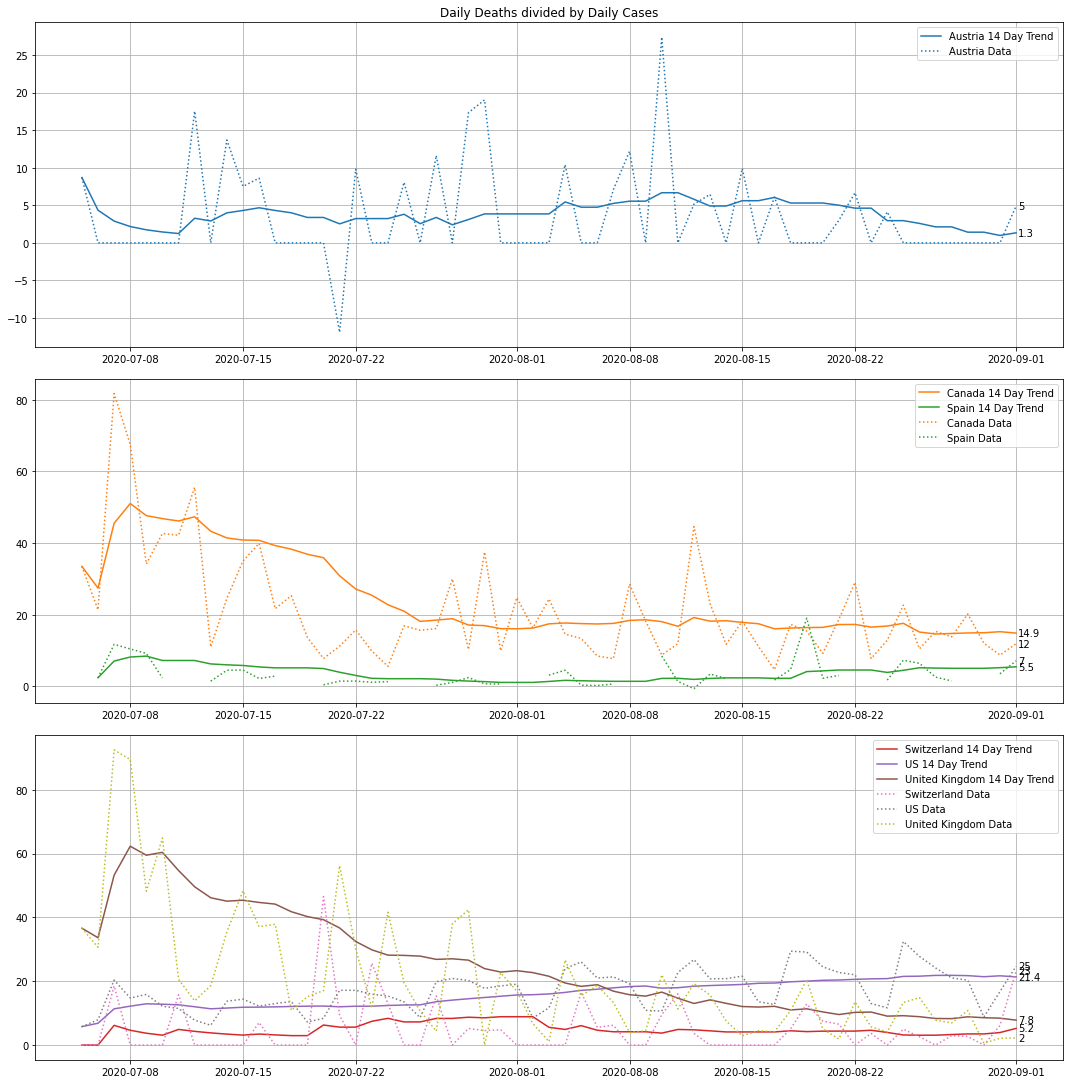

In [31]:
dd_dc = dailies_deaths / dailies_cases
plot_dailies(dd_dc.mul(1000), "Daily Deaths divided by Daily Cases", splits, [])

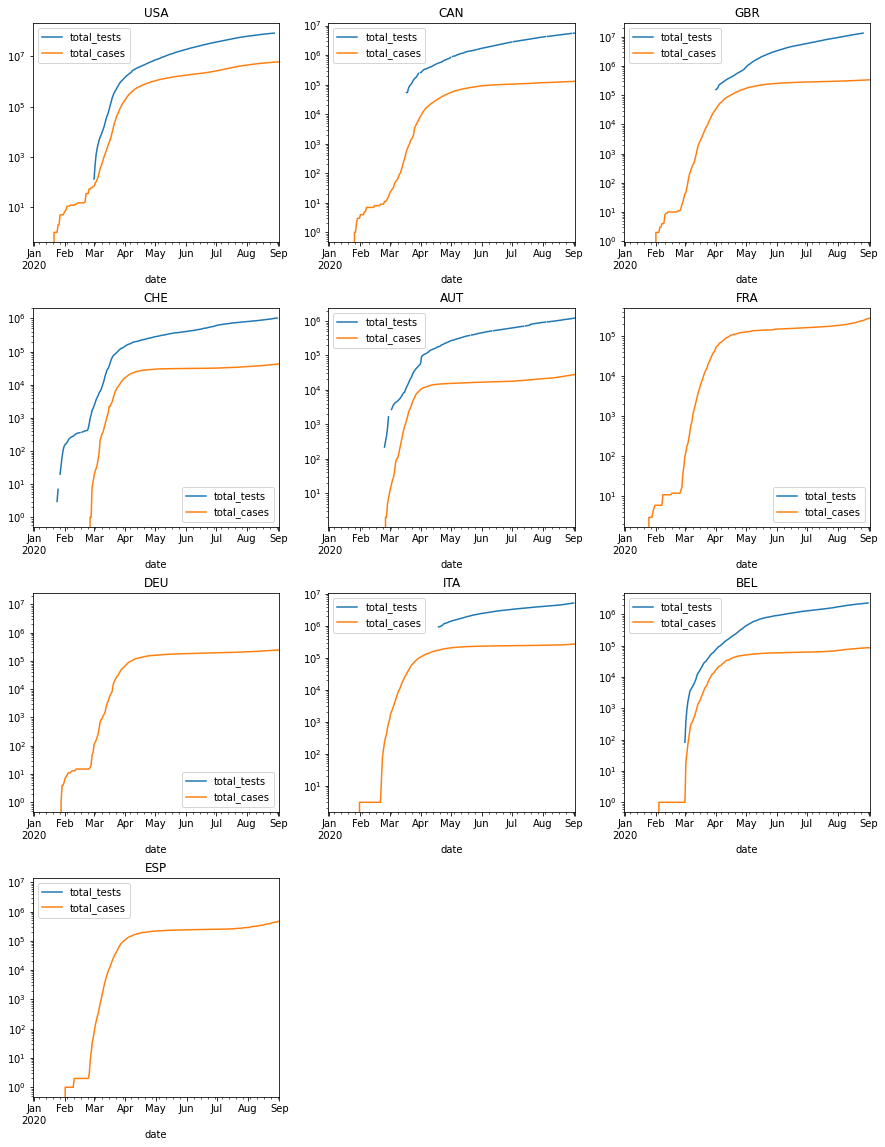

In [23]:
from math import ceil
testing_countries = ["USA", "CAN", "GBR", "CHE", "AUT", "FRA", "DEU", "ITA", "BEL", "ESP"]
cols = 3
rows = ceil(len(testing_countries) / 2)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.3)

data = owid_data_raw[owid_data_raw["iso_code"].isin(testing_countries)].set_index("date")
data = data[["iso_code", "total_tests", "total_cases"]]
data.index = pd.to_datetime(data.index)

for idx, val in enumerate(testing_countries):
    ax = get_axis(axes, idx)
    d = data[data["iso_code"] == val]
    d[["total_tests", "total_cases"]].plot(ax=ax, logy=True, title=val)

for i in range(idx + 1, rows * cols):
    get_axis(axes, i).set_visible(False)

plt.show()